In [1]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

Se analizara la data de entrenamiento en forma de parquet usando la libreria polars para mayor eficiencia. Se convirtio a parquet anteriormente utilizando duck db

In [2]:
df_train = pl.read_parquet("data/train.parquet")
df_test = pl.read_csv("data/test.csv")

In [3]:
df_train.shape

(184903890, 7)

In [4]:
df_test.shape

(18790469, 7)

La data de entrenamiento es de 189 millones de filas, mientras que el conjunto de prueba son 19 millones. Afortunadamente, los organizadores del concurso tambien proporcionaron un archivo train_sample.csv

In [5]:
df_train_sample = pl.read_csv("data/train_sample.csv")
df_train_sample.sample(5, seed=42)

ip,app,device,os,channel,click_time,attributed_time,is_attributed
i64,i64,i64,i64,i64,str,str,i64
61224,2,1,19,237,"""2017-11-07 09:05:53""",null,0
77626,9,1,22,445,"""2017-11-08 03:59:41""",null,0
4019,3,1,13,452,"""2017-11-08 17:00:00""",null,0
53964,7,1,13,101,"""2017-11-09 08:32:49""",null,0
143233,12,1,13,497,"""2017-11-06 16:50:59""",null,0


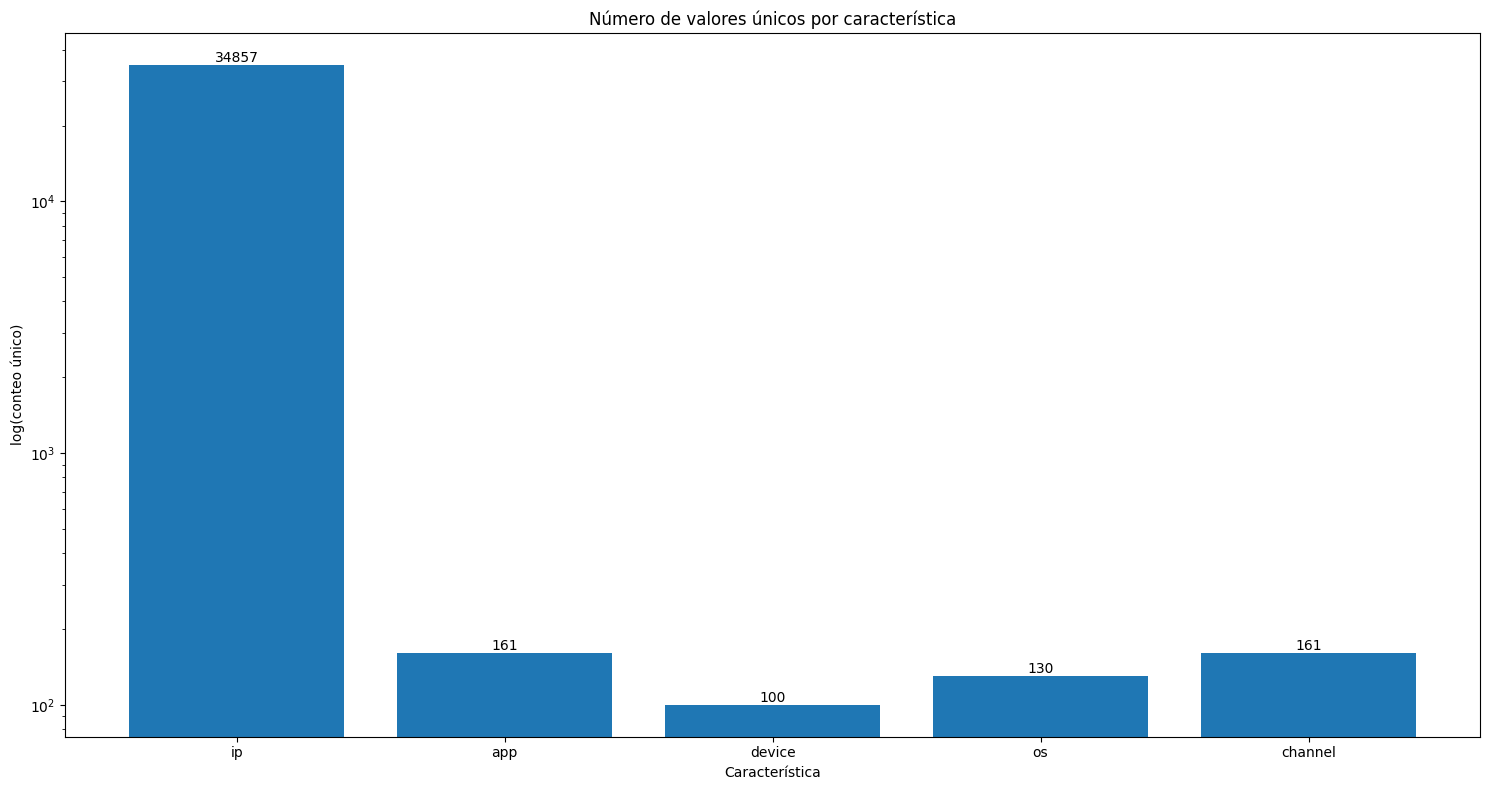

In [6]:
columnas = ['ip', 'app', 'device', 'os', 'channel']
conteos_unicos = []

indice = 0
while indice < len(columnas):
    nombre_columna = columnas[indice]
    resultado = df_train_sample.select(pl.col(nombre_columna).n_unique().alias("n"))
    conteo = int(resultado["n"][0])
    conteos_unicos.append(conteo)
    indice = indice + 1

plt.figure(figsize=(15, 8))
eje = plt.gca()
barras = eje.bar(columnas, conteos_unicos)

eje.set_yscale('log')
eje.set_xlabel('Característica')
eje.set_ylabel('log(conteo único)')
eje.set_title('Número de valores únicos por característica')

indice = 0
while indice < len(barras):
    barra = barras[indice]
    altura = barra.get_height()
    eje.text(barra.get_x() + barra.get_width() / 2.0,
             altura,
             str(conteos_unicos[indice]),
             ha="center",
             va="bottom")
    indice = indice + 1

plt.tight_layout()
plt.show()


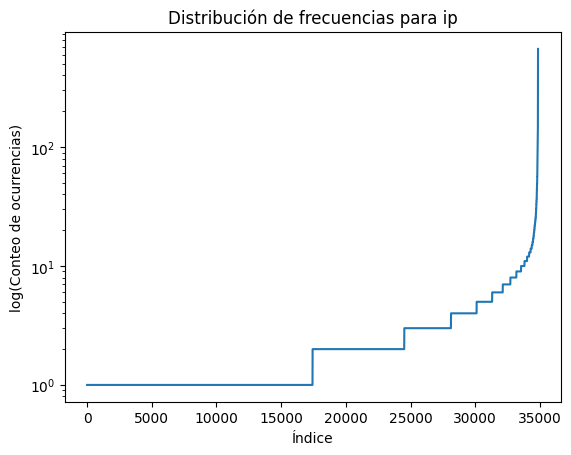

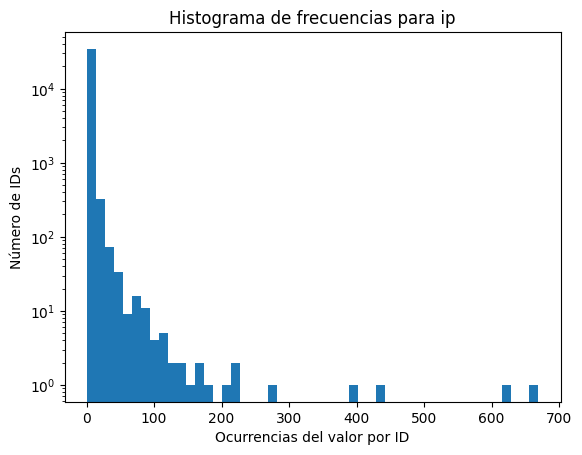

Variable 'ip': | Valores únicos: 34857 | Más común: 669 | Menos común: 1 | conteo>10: 3.02% | conteo>100: 0.06% | conteo>1000: 0.0%


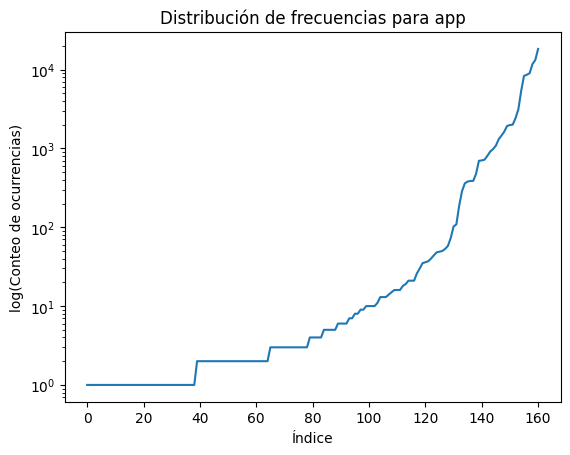

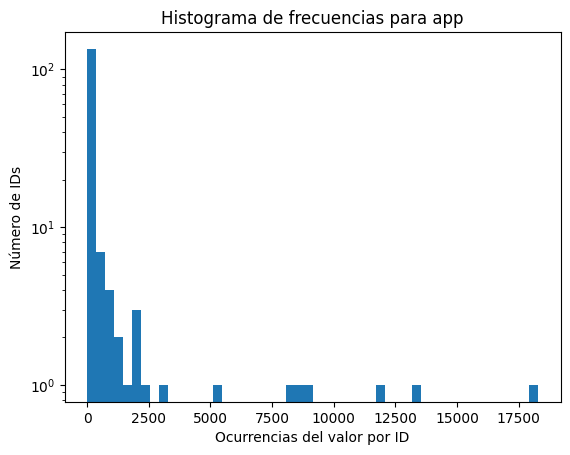

Variable 'app': | Valores únicos: 161 | Más común: 18279 | Menos común: 1 | conteo>10: 36.02% | conteo>100: 19.25% | conteo>1000: 9.94%


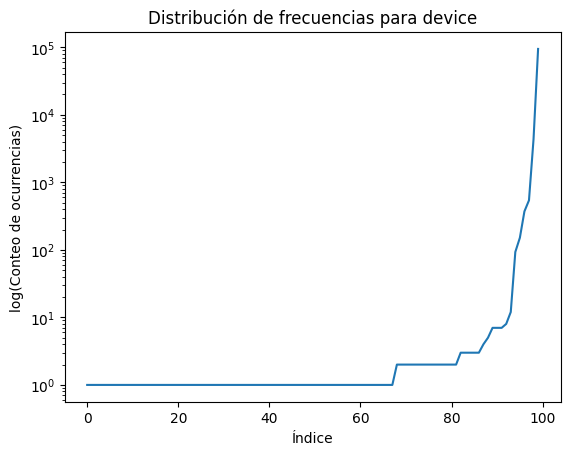

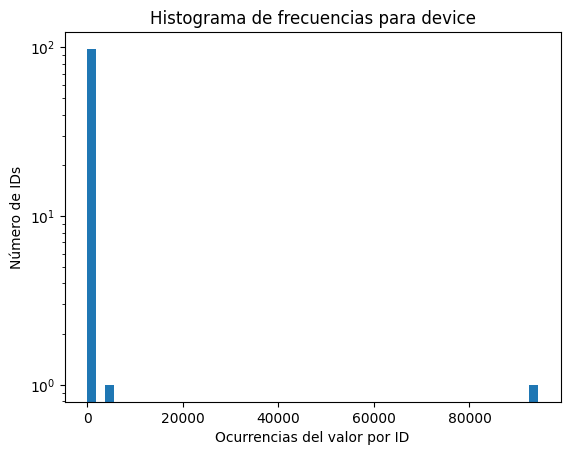

Variable 'device': | Valores únicos: 100 | Más común: 94338 | Menos común: 1 | conteo>10: 7.0% | conteo>100: 5.0% | conteo>1000: 2.0%


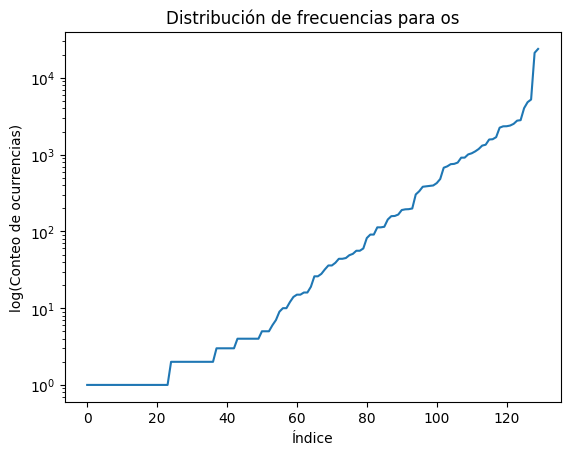

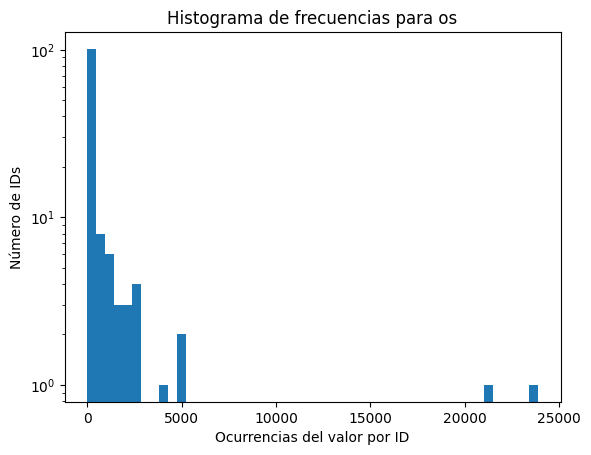

Variable 'os': | Valores únicos: 130 | Más común: 23870 | Menos común: 1 | conteo>10: 55.38% | conteo>100: 36.15% | conteo>1000: 16.15%


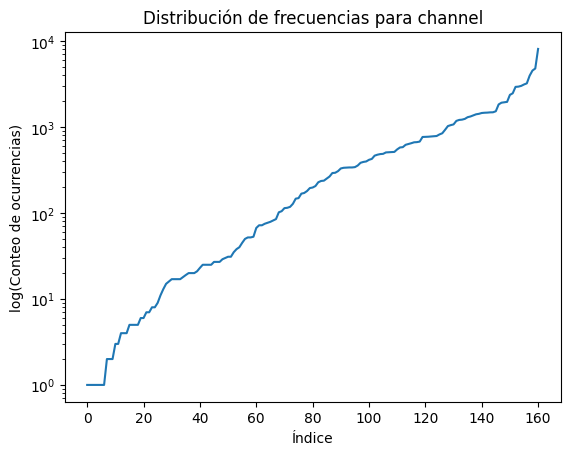

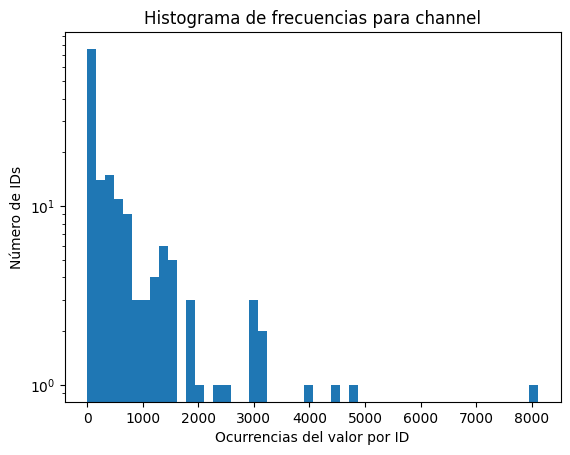

Variable 'channel': | Valores únicos: 161 | Más común: 8114 | Menos común: 1 | conteo>10: 83.85% | conteo>100: 57.76% | conteo>1000: 20.5%


In [9]:
lista_unicos = []
indice = 0
while indice < len(columnas):
    nombre_columna = columnas[indice]
    valor_unicos = int(df_train_sample.select(pl.col(nombre_columna).n_unique()).item())
    lista_unicos.append(valor_unicos)
    indice = indice + 1

indice = 0
while indice < len(columnas):
    nombre_columna = columnas[indice]
    unicos = lista_unicos[indice]

    # conteos por valor
    agrupacion = (
        df_train_sample
        .group_by(nombre_columna)
        .agg(pl.len().alias("conteo"))
    )

    # serie de conteos ordenada (ascendente)
    serie_conteos = agrupacion.select("conteo").to_series()
    conteos_ordenados = serie_conteos.sort().to_list()

    # grafico de líneas con escala logarítmica en Y
    figura = plt.figure()
    ejes = figura.add_subplot(1, 1, 1)
    linea = ejes.plot(conteos_ordenados)
    ejes.set_yscale("log")
    plt.title(f"Distribución de frecuencias para {nombre_columna}")
    plt.ylabel("log(Conteo de ocurrencias)")
    plt.xlabel("Índice")
    plt.show()

    # histograma de los conteos con escala logarítmica en Y
    figura = plt.figure()
    ejes = figura.add_subplot(1, 1, 1)
    ejes.hist(conteos_ordenados, bins=50)
    ejes.set_yscale("log")
    plt.title(f"Histograma de frecuencias para {nombre_columna}")
    plt.ylabel("Número de IDs")
    plt.xlabel("Ocurrencias del valor por ID")
    plt.show()

    # métricas resumen
    maximo_conteo = int(serie_conteos.max())
    minimo_conteo = int(serie_conteos.min())

    umbrales = [10, 100, 1000]
    proporciones_mayores = []
    j = 0
    total_ids = agrupacion.height
    while j < len(umbrales):
        valor = umbrales[j]
        cantidad_mayores = agrupacion.filter(pl.col("conteo") > valor).height
        if total_ids > 0:
            porcentaje = round((cantidad_mayores / total_ids) * 100.0, 2)
        else:
            porcentaje = 0.0
        proporciones_mayores.append(porcentaje)
        j = j + 1

    print(
        "Variable '{}': | Valores únicos: {} | Más común: {} | Menos común: {} | "
        "conteo>10: {}% | conteo>100: {}% | conteo>1000: {}%".format(
            nombre_columna,
            unicos,
            maximo_conteo,
            minimo_conteo,
            proporciones_mayores[0],
            proporciones_mayores[1],
            proporciones_mayores[2],
        )
    )

    indice = indice + 1

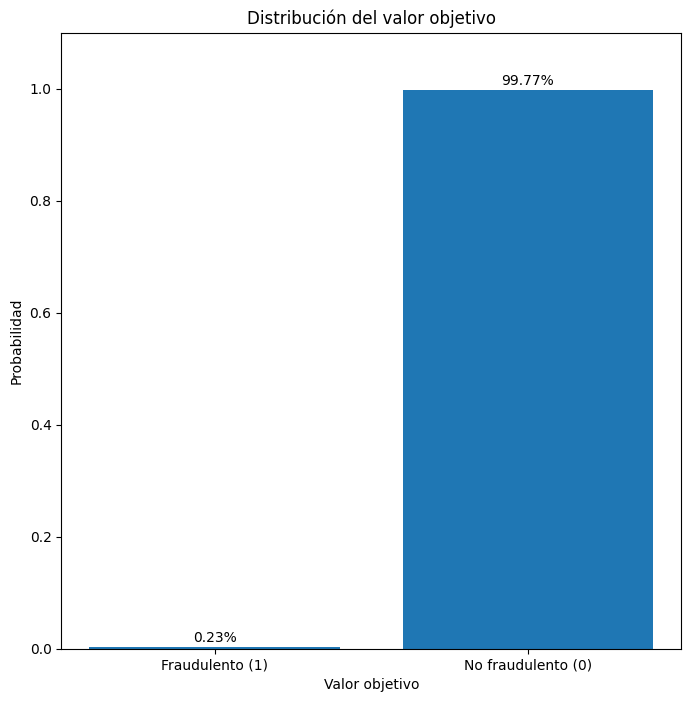

In [10]:
total_filas = df_train_sample.height
if total_filas > 0:
    conteo_fraude = df_train_sample.filter(pl.col("is_attributed") == 1).height
    proporcion_fraude = conteo_fraude / float(total_filas)
else:
    proporcion_fraude = 0.0

proporcion_no_fraude = 1.0 - proporcion_fraude

etiquetas = ["Fraudulento (1)", "No fraudulento (0)"]
valores = [proporcion_fraude, proporcion_no_fraude]

plt.figure(figsize=(8, 8))
ejes = plt.gca()
barras = ejes.bar(etiquetas, valores)

ejes.set_xlabel("Valor objetivo")
ejes.set_ylabel("Probabilidad")
ejes.set_title("Distribución del valor objetivo")

indice = 0
while indice < len(barras):
    barra = barras[indice]
    altura = barra.get_height()
    porcentaje = round(valores[indice] * 100.0, 2)
    ejes.text(
        barra.get_x() + barra.get_width() / 2.0,
        altura + 0.01,
        "{}%".format(porcentaje),
        ha="center"
    )
    indice = indice + 1

plt.ylim(0.0, 1.1)
plt.show()